# Toward a broad-coverage implementation of self-organization for sentence comprehension

## Parsing algorithm
Initial state: at least two words have been entered; no links exist. Parameters: temperature/noise level, stopping criterion (uncertainty of running average energy).
1. Select two attachment sites uniformly at random
    1. If the link does not exist, add it to the list of links.
    2. If the link does exist, remove it from the list of links.
    3. No other moves are allowed.
2. Calculate the energy of the new and old states
3. Metropolis algorithm: if the new state has lower energy than the previous one, make it the new current state; otherwise, change to the new state with probability $\exp\left(-(E_{new}-E_{old})/T\right)$. This is related to the transition rate per time $W_{old\rightarrow new} = \tau \min\left(1, \exp\left(-(E_{new}-E_{old})/T\right)\right)$, where $\tau$ sets the time scale in ms.
4. Record the state, energy, running average energy, and running standard error (i.e., half-width of 95% CI) of the energy every $nwords^{nwords-1}$ trials (once every Monte Carlo sweep (MCS), Landau & Binder, 2009, p. 71)
5. If half-width drops below threshold, input next word, or stop if all words have been input.

## Garden paths
- Linear order: forgot that-solution/solution was
- Correct struct.: forgot $\rightarrow$ was, that-/solution $\leftarrow$ was
- GP struct.: forgot $\rightarrow$ solution

## Locally coherent structures
- Linear order: smiled-at player tossed/thrown
- Correct struct.: smiled-at $\rightarrow$ player, player $\rightarrow$ tossed/thrown
- LC struct.: player $\leftarrow$ tossed

## Ambiguity advantage
- Linear order: the car/driver/son of the driver/car/driver with the mustache
- High attch.: driver $\rightarrow$ car, driver $\rightarrow$ mustache
- Low attch.: car $\rightarrow$ driver, driver $\rightarrow$ mustache
- Ambig.: son $\rightarrow$ driver, son $\rightarrow$ mustache

In [1]:
from itertools import product
from collections import defaultdict
import random
#from math import exp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option('display.max_rows', 500)
import numpy as np
from scipy import stats

In [8]:
# pseudo-PPMI matrix in nested dict
# PPMI = pointwise mutual information is a measure of how strongly associated two things are
# and is one way of implementing the harmony/well-formedness of a link
# {gov: {dep: PPMI}}
words = ['forgot', 'that-solution', 'solution', 'was',
         'smiled-at', 'player', 'tossed', 'thrown',
         'car', 'of-car', 'driver', 'of-driver', 'son', 'mustache']
ppmi = defaultdict(dict)

# GP
ppmi['forgot']['solution'] = 1.0
ppmi['was']['solution'] = 1.0
ppmi['was']['that-solution'] = 1.0
ppmi['forgot']['was'] = 1.0

# LC
ppmi['smiled-at']['player'] = 1.0
ppmi['player']['tossed'] = 1.0
ppmi['player']['thrown'] = 1.0
ppmi['tossed']['player'] = 1.0

# AA
ppmi['driver']['of-car'] = 1.0
ppmi['car']['of-driver'] = 1.0
ppmi['of-driver']['mustache'] = 1.0
ppmi['driver']['mustache'] = 1.0

ppmi['son']['of-driver'] = 1.0
ppmi['son']['mustache'] = 1.0

# The grammar
for k, v in ppmi.items():
    for kn, vn in ppmi[k].items():
        if vn != 0:
            print([k, kn, vn])

['forgot', 'solution', 1.0]
['forgot', 'was', 1.0]
['was', 'solution', 1.0]
['was', 'that-solution', 1.0]
['smiled-at', 'player', 1.0]
['player', 'tossed', 1.0]
['player', 'thrown', 1.0]
['tossed', 'player', 1.0]
['driver', 'of-car', 1.0]
['driver', 'mustache', 1.0]
['car', 'of-driver', 1.0]
['of-driver', 'mustache', 1.0]
['son', 'of-driver', 1.0]
['son', 'mustache', 1.0]


In [9]:
# LC control, LC, GP control, GP
sents = [['forgot', 'that-solution', 'was'], ['forgot', 'solution', 'was'],
         ['smiled-at', 'player', 'thrown'], ['smiled-at', 'player', 'tossed'],
         ['driver', 'of-car', 'mustache'], ['car', 'of-driver', 'mustache'], ['son', 'of-driver', 'mustache']]
conds = ['GP-Unambig', 'GP-Ambig',
         'LC-Unambig', 'LC-Ambig',
         'AA-High', 'AA-Low', 'AA-Ambig']

In [10]:
# Defining the energy fn.
def energy(wordssofar, links, ppmidict):
    e = abs(len(links) - len(wordssofar) + 1) - sum(ppmi[l[0]][l[1]] for l in links)
    return e

In [11]:
wsf = ['forgot', 'solution']
energy(wsf, [['forgot', 'solution']], ppmi) - energy(wsf, [], ppmi)

-2.0

## Fixed precision stopping rule
Jones et al. (2006), Flegal et al. (2008): run until confidence interval half-width reaches some threshold for precision. Something similar is recommended in Kruschke (2015). See R code of `mcmcse` for implementation example.

Uses non-overlapping batches of MCS, which is probably good b/c each MCS is probably quite correlated with previous ones.

In [6]:
def stop(ehist, minsteps, halfwidth, quantile):
    # Uses block averages method from Jones et al. (2006); code modified from R package mcmcse
    n = len(ehist)
    b = int(np.floor(np.sqrt(n)))  # Number of batches
    a = int(np.floor(n / b))  # Number of sweeps per batch
    blockmeans = list(map(lambda j: np.mean(ehist[(j-1)*b:j*b-1]), np.arange(1, a+1)))
    emean = np.mean(blockmeans)
    blockvar = b / max(1, a-1) * np.sum((blockmeans - emean)**2)
    se = np.sqrt(blockvar / n)
    # Getting critical t-value
    tval = stats.t.ppf(quantile, df=b)
    # Calculating the p(n) function from Jones et al. (2006)
    pn = halfwidth * (n <= minsteps)
    if tval*se + pn < halfwidth:
        return True
    else:
        return False
    
es = np.array([1, 0, 0.5, 1, 0, 0.25, 0.25, 2, 3, 0.1])
stop(es, 20, 0.75, 0.975)

False

In [7]:
# Defining the running function
def run(sent, ppmi, nmin, epsilon, T, quantile=0.975, maxsweeps=2000):
    links = []
    currdat = []  # For storing the current run's data
    wordnr = 2  # starting at the second word
    wordssofar = sent[:wordnr]
    word2sweeps = word3sweeps = np.nan  # in case it times out
    # Loop over Monte Carlo sweeps
    for sweep in range(maxsweeps):
        # In here, will have to do convergence checking and adding additional words
        # Loop over individual parse change attempts = trials
        for trial in range(len(wordssofar)**(len(wordssofar)-1)):
            # Sort so that things are counted properly
            if links:
                links.sort()
            curre = energy(wordssofar, links, ppmi)
            newpair = random.sample(wordssofar, 2)  # Should sample without replacement
            newpairrev = newpair.copy()[::-1]  # Reversing the gov.-dep. relation; only important here, where we don't really distinguish between head and dep. attch. sites
            # Check that the new pair is in the PPMI dict
            if (newpair[0] not in ppmi.keys()) or (newpair[1] not in ppmi[newpair[0]].keys()):
                newe = curre
                newlinks = links.copy()
                #continue
            # Parsing
            # If the proposed link already exists, delete it
            elif newpair in links:
                newlinks = [x for x in links if x != newpair]  #[x for x in newlinks if x != newpair]
                newe = energy(wordssofar, newlinks, ppmi)
            # Otherwise, add the new link if the reverse is not already there and the dependent is not already attached
            # Special check for garden paths: 'forgot' can only have one complement, clausal or nominal
            elif (newpair not in links) and (newpairrev not in links) and (newpair[1] not in [x[1] for x in links]) and (newpair[0] not in [x[0] for x in links if x[0] == 'forgot']):
                newlinks = links.copy()
                newlinks.append(newpair)
                newe = energy(wordssofar, newlinks, ppmi)
            else:
                newe = curre
                newlinks = links.copy()
                #continue
            newlinks.sort()
            # Metropolis
            pr = min(1, np.exp(-(newe - curre) / T))
            if np.random.uniform(0, 1) <= pr:
                links = newlinks
                curre = newe
        #print(curre, links)
        # Save history
        currdat.append([wordnr, sweep, trial*sweep, curre, wordssofar, links])
        # Do stop checking checking; KLUDGY!!!
        if stop([x[3] for x in currdat if (x[0] == wordnr)], nmin, epsilon, quantile):
            if wordnr == 2:
                # Input next word
                wordssofar = sent
                wordnr = 3
                word2sweeps = sweep + 1  # Correct for start-at-0
            else:
                word3sweeps = sweep - word2sweeps + 1
                break
    return (word2sweeps, word3sweeps)
test = run(['forgot', 'solution', 'was'], ppmi, 20, 0.15, 1)
print(test)

/Users/garrettsmith/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/garrettsmith/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(21, 784)


In [12]:
# Creating an empty data frame to store the data
maxsweeps = 2000  # setting time out
nminvals = np.array([0, 5, 20, 50])  # 100 always similar to 50
epsvals = np.array([0.1, 0.15, 0.2, 0.25])  # 0.05 seems too small; always times out; 1, 0.5, 0.25 same
Tvals = np.array([0.1, 0.25, 0.5, 0.75, 1.0, 2.0, 5.0])  # 0.001 caused overflow errors...; 0.01 similar to 0.1
nruns = 5
runs = np.arange(0, nruns)
dat = pd.DataFrame(list(product(nminvals, epsvals, Tvals, sents, runs)),
                   columns=['nmin', 'epsilon', 'T', 'sentence', 'run'])

dat['word2'] = 0.0
dat['word3'] = 0.0
print(dat.shape)
dat.head()

(3920, 7)


,nmin,epsilon,T,sentence,run,word2,word3
0,0,0.1,0.1,"[forgot, that-solution, was]",0,0.0,0.0
1,0,0.1,0.1,"[forgot, that-solution, was]",1,0.0,0.0
2,0,0.1,0.1,"[forgot, that-solution, was]",2,0.0,0.0
3,0,0.1,0.1,"[forgot, that-solution, was]",3,0.0,0.0
4,0,0.1,0.1,"[forgot, that-solution, was]",4,0.0,0.0


In [9]:
#%%time
# A function to parallelize the runs
from multiprocessing import Pool, cpu_count
from tqdm import tqdm_notebook
def f(x):
    _, y = x  # strip index from iterator
    w2, w3 = run(y['sentence'], ppmi, y['nmin'], y['epsilon'], y['T'], quantile=0.975, maxsweeps=maxsweeps)
    return w2, w3
    
with Pool(cpu_count()) as p:
    lst = list(tqdm_notebook(p.imap(f, dat.iterrows(), chunksize=nruns), total=len(dat)))

dat[['word2', 'word3']] = lst
dat.head()

/Users/garrettsmith/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/garrettsmith/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/garrettsmith/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/garrettsmith/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/garrettsmith/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/garrettsmith/miniconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.d

,nmin,epsilon,T,sentence,run,word2,word3
0,0,0.1,0.1,"[forgot, that-solution, was]",0,4,4.0
1,0,0.1,0.1,"[forgot, that-solution, was]",1,4,4.0
2,0,0.1,0.1,"[forgot, that-solution, was]",2,4,56.0
3,0,0.1,0.1,"[forgot, that-solution, was]",3,4,4.0
4,0,0.1,0.1,"[forgot, that-solution, was]",4,4,56.0


In [10]:
dat.to_csv(''.join(['./AMLaP', str(nruns), 'Runs.csv']))
dat.shape

(392000, 7)

In [13]:
dat = pd.read_csv('./AMLaP500Runs.csv', index_col=0, converters={'sentence': lambda x: x[1:-1].replace("'", '').replace(' ', '').split(',')})
#print(dat.shape)
print(dat.columns)
print(dat.sentence.head())

Index(['nmin', 'epsilon', 'T', 'sentence', 'run', 'word2', 'word3'], dtype='object')
0    [forgot, that-solution, was]
1    [forgot, that-solution, was]
2    [forgot, that-solution, was]
3    [forgot, that-solution, was]
4    [forgot, that-solution, was]
Name: sentence, dtype: object


In [14]:
dat['sent_str'] = ['_'.join(map(str, l)) for l in dat['sentence']]
dat.head()
dat['construction'] = ['GP' if (x.startswith('forgot')) else 'LC' if (x.startswith('smiled')) else 'AA' for x in dat['sent_str']]
dat['condition'] = ['GP-Unambig' if (x.startswith('forgot_that-')) else 'GP-Ambig' if (x.startswith('forgot_solution')) else 'LC-Ambig' if (x.endswith('tossed')) else 'LC-Unambig' if (x.endswith('thrown')) else 'AA-High' if x=='driver_of-car_mustache' else 'AA-Low' if x=='car_of-driver_mustache' else 'AA-Ambig' for x in dat['sent_str']]
dat.head()

,nmin,epsilon,T,sentence,run,word2,word3,sent_str,construction,condition
0,0,0.1,0.1,"[forgot, that-solution, was]",0,4,4.0,forgot_that-solution_was,GP,GP-Unambig
1,0,0.1,0.1,"[forgot, that-solution, was]",1,4,4.0,forgot_that-solution_was,GP,GP-Unambig
2,0,0.1,0.1,"[forgot, that-solution, was]",2,4,4.0,forgot_that-solution_was,GP,GP-Unambig
3,0,0.1,0.1,"[forgot, that-solution, was]",3,4,144.0,forgot_that-solution_was,GP,GP-Unambig
4,0,0.1,0.1,"[forgot, that-solution, was]",4,4,4.0,forgot_that-solution_was,GP,GP-Unambig


In [15]:
# Any time-outs?
print(dat[dat.word2 >= maxsweeps-10].shape, dat[dat.word3 >= maxsweeps-10].shape)
#print(dat[dat.word2 == (maxsweeps-1)], dat[dat.word3 == (maxsweeps-1)])
#print(dat.word2.max(), dat.word3.max())

(0, 10) (1, 10)


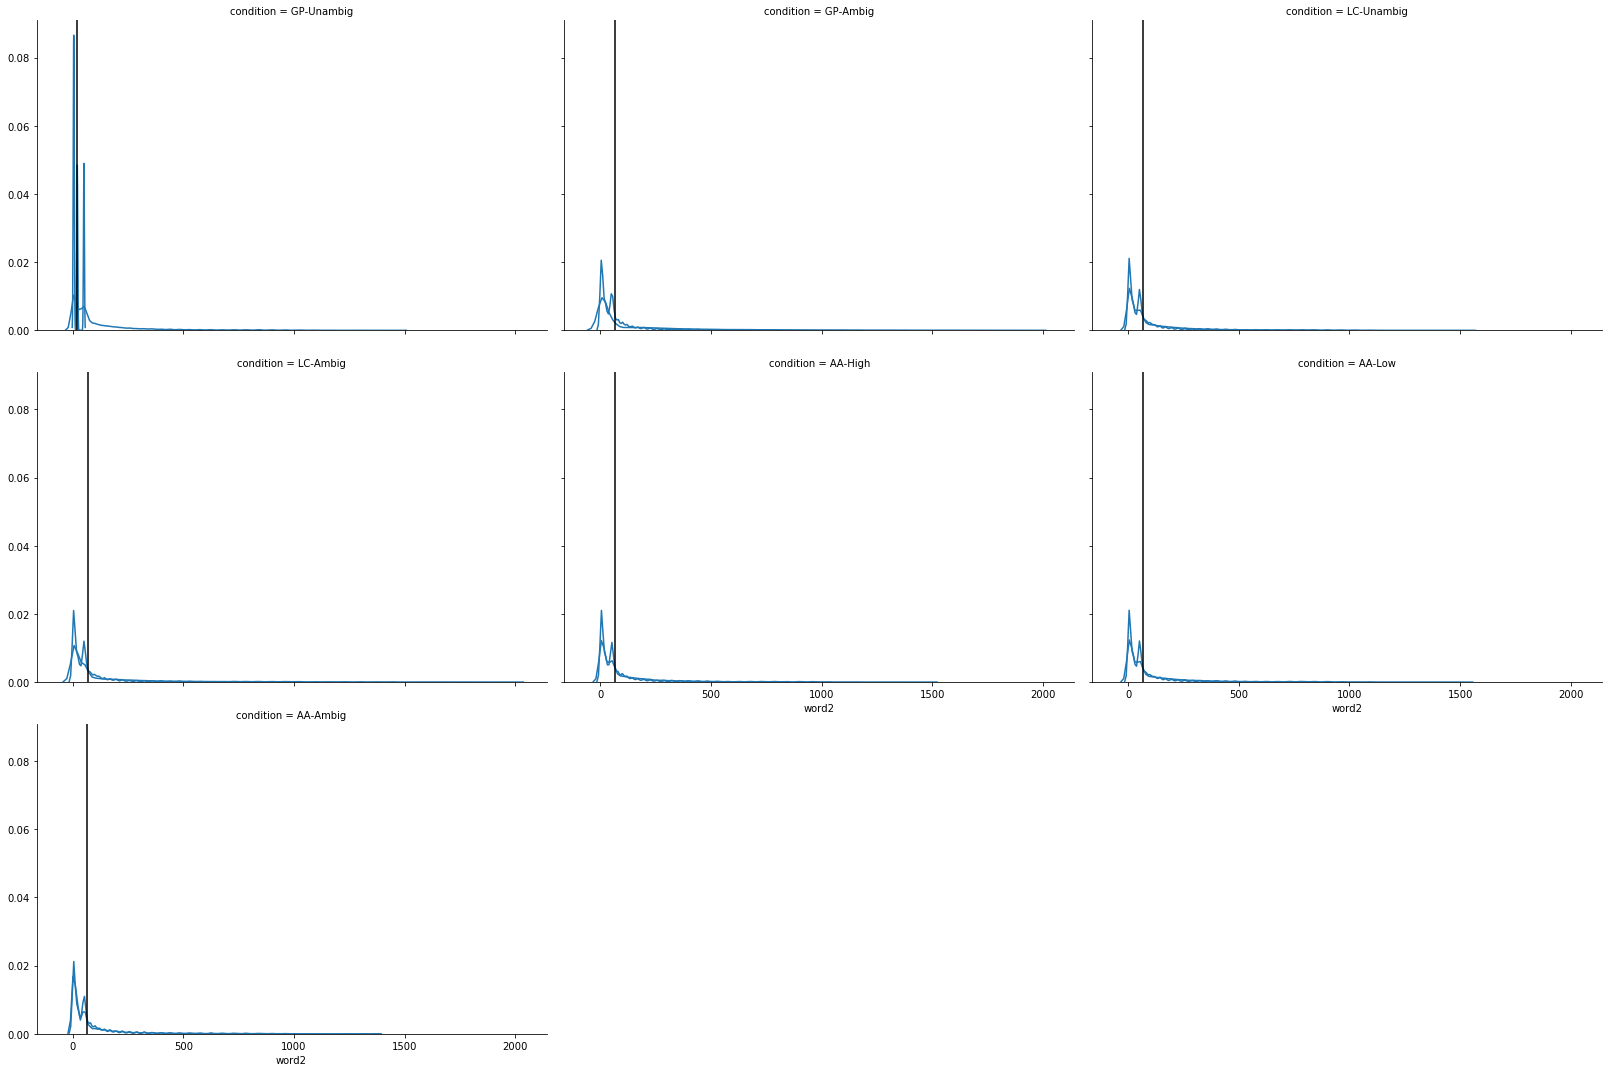

In [14]:
g = sns.FacetGrid(dat, col='condition', col_wrap=3,#hue='WordNr', col_order=['GP-Control', 'LC-Control', 'GP', 'LC', 'High', 'Low'],
                  sharex=True, sharey=True, height=5, aspect=1.5)
g = g.map(sns.distplot, 'word2', hist=False)
g = g.map(sns.distplot, 'word3', hist=False)
g = g.map(lambda x, **kw: plt.axvline(x.mean(), color="k"), 'word2')
plt.show()

<Figure size 576x432 with 0 Axes>

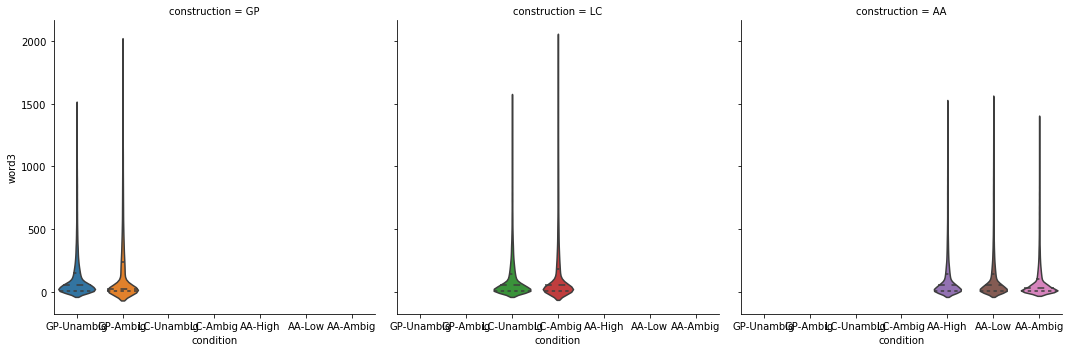

In [15]:
plt.figure(figsize=(8, 6))
sns.catplot(data=dat, x='condition', y='word3', estimator=np.median, #ci=lambda x: np.quantile(x, [0.25, 0.75]),#'sd',
            dodge=True, #palette=['C2', 'C4', 'C6', 'C8'],
            col='construction', kind='violin', inner='quartiles')#, width=2)
#plt.ylim(-10, 500)
plt.show()

In [13]:
dat.groupby(['condition']).word2.describe()

,count,mean,std,min,25%,50%,75%,max
condition,,,,,,,,
AA-Ambig,56000.0,66.965357,94.019105,4.0,6.0,42.0,80.0,841.0
AA-High,56000.0,67.246911,94.357169,4.0,6.0,42.0,80.0,822.0
AA-Low,56000.0,67.058357,94.346490,4.0,6.0,42.0,80.0,810.0
GP-Ambig,56000.0,66.963661,94.007146,4.0,6.0,42.0,80.0,784.0
GP-Unambig,56000.0,20.500000,18.795114,4.0,5.5,13.5,28.5,51.0
LC-Ambig,56000.0,67.344339,94.622583,4.0,6.0,42.0,80.0,812.0
LC-Unambig,56000.0,66.631232,93.733096,4.0,6.0,42.0,80.0,809.0


In [14]:
dat.groupby(['condition']).word3.describe()

,count,mean,std,min,25%,50%,75%,max
condition,,,,,,,,
AA-Ambig,56000.0,95.325071,161.662203,4.0,6.0,27.0,100.0,1369.0
AA-High,55999.0,124.530063,200.433364,4.0,6.0,51.0,144.0,1485.0
AA-Low,55999.0,124.385328,199.909855,4.0,6.0,51.0,144.0,1520.0
GP-Ambig,55283.0,192.404464,325.198385,4.0,6.0,21.0,240.5,1950.0
GP-Unambig,56000.0,130.628679,199.126824,4.0,9.0,51.0,146.0,1472.0
LC-Ambig,55408.0,172.340438,304.236650,4.0,6.0,51.0,182.0,1990.0
LC-Unambig,56000.0,125.190125,200.623108,4.0,6.0,51.0,144.0,1533.0


In [16]:
# Reshape lc data frame to have sep. word{2,3}{Un-, Ambig} columns; calc. difference column.
lc = dat[dat['construction'] == 'LC']
lcun = lc[lc['condition']=='LC-Unambig']
lcun.rename({'word2':'word2unambig', 'word3':'word3unambig'}, axis=1, inplace=True)
lcun.head()
lcam = lc[lc['condition']=='LC-Ambig']

lcwide = lcun.copy()
lcwide['word2ambig'] = lcam['word2'].values
lcwide['word3ambig'] = lcam['word3'].values

lcwide['word2diff'] = lcwide['word2ambig'] - lcwide['word2unambig']
lcwide['word3diff'] = lcwide['word3ambig'] - lcwide['word3unambig']

# AA
aa = dat[dat['construction']=='AA']
aahigh = aa[aa['condition']=='AA-High']
aalow = aa[aa['condition']=='AA-Low']
aaamb = aa[aa['condition']=='AA-Ambig']
aahigh.rename({'word2':'word2high', 'word3':'word3high'}, axis=1, inplace=True)

aawide = aahigh.copy()
aawide['word2low'] = aalow['word2'].values
aawide['word3low'] = aalow['word3'].values
aawide['word2ambig'] = aaamb['word2'].values
aawide['word3ambig'] = aaamb['word3'].values

aawide['word2highlow'] = aawide['word2high'] - aawide['word2low']
aawide['word3highlow'] = aawide['word3high'] - aawide['word3low']
aawide['word2highambig'] = aawide['word2high'] - aawide['word2ambig']
aawide['word3highambig'] = aawide['word3high'] - aawide['word3ambig']
aawide['word2lowambig'] = aawide['word2low'] - aawide['word2ambig']
aawide['word3lowambig'] = aawide['word3low'] - aawide['word3ambig']
# Note coding: ambig - low attch.
aawide['word3diff'] = aawide['word3ambig'] - aawide['word3low']

# GP
gp = dat[dat['construction'] == 'GP']
gpam = gp[gp['condition']=='GP-Ambig']
gpam.rename({'word2':'word2ambig', 'word3':'word3ambig'}, axis=1, inplace=True)
gpun = gp[gp['condition']=='GP-Unambig']

gpwide = gpam.copy()
gpwide['word2unambig'] = gpun['word2'].values
gpwide['word3unambig'] = gpun['word3'].values

gpwide['word2ambigunambig'] = gpwide['word2ambig'] - gpwide['word2unambig']
gpwide['word3diff'] = gpwide['word3ambig'] - gpwide['word3unambig']

/Users/garrettsmith/miniconda3/envs/py37/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
# For custom cmap
from matplotlib.colors import TwoSlopeNorm  #DivergingNorm
vmin = vmax = 0
# Finding min/max values for heatmap
for nm in nminvals:
    lpivot = lcwide[lcwide['nmin']==nm].pivot_table(index='epsilon', columns='T', values='word3diff', aggfunc='median')
    apivot = aawide[aawide['nmin']==nm].pivot_table(index='epsilon', columns='T', values='word3diff', aggfunc='median')
    gpivot = gpwide[gpwide['nmin']==nm].pivot_table(index='epsilon', columns='T', values='word3diff', aggfunc='median')
    lcmin = lpivot.values.min()
    acmin = apivot.values.min()
    gcmin = gpivot.values.min()
    lcmax = lpivot.values.max()
    acmax = apivot.values.max()
    gcmax = gpivot.values.max()
    cmin = min([lcmin, acmin, gcmin])
    cmax = max([lcmax, acmax, gcmax])
    if cmin <= vmin:
        vmin = cmin
    if cmax >= vmax:
        vmax = cmax
print(vmin, vmax)
divnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)


-164.0 888.5


In [37]:
from matplotlib import rc
rc('text', usetex=False)

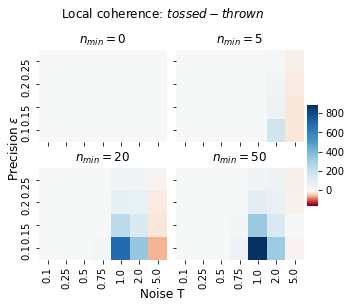

In [40]:
# Plot: for each nmin, make heatmap w/ diff as col, x=T, y=epsilon
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(4,4), sharex=True, sharey=True, constrained_layout=True)
cbar_ax = fig.add_axes([1.0, 0.3, 0.04, .35])

for i, nm in enumerate(nminvals):
    pivot = lcwide[lcwide['nmin']==nm].pivot_table(index='epsilon', columns='T', values='word3diff', aggfunc='median')
    s = sns.heatmap(pivot, ax=axs.flat[i], cmap='RdBu', norm=divnorm,
                vmin=vmin, vmax=vmax,
                cbar=True, cbar_ax=cbar_ax)#, cbar_kws={'label': 'Time steps'})
    axs.flat[i].invert_yaxis()
    axs.flat[i].set_title(r'$n_{{min}} = ${}'.format(nm))
    axs.flat[i].set(ylabel='', xlabel='')
    
fig.suptitle('Local coherence: $tossed - thrown$')
fig.text(0.5, -0.02, 'Noise T', ha='center', fontsize=12)
fig.text(-0.04, 0.5, 'Precision $\\epsilon$', va='center', rotation='vertical', fontsize=12)
plt.savefig(''.join(['LC', str(nruns), '.pdf']), bbox_inches='tight')
plt.show()

In [33]:
lcwide.groupby(['nmin', 'epsilon', 'T']).word3diff.agg(['median', lambda x: np.quantile(x, 0.25), lambda x: np.quantile(x, 0.75)])

median  <lambda_0>  <lambda_1>
nmin epsilon T                                   
0    0.10    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0         NaN         NaN
             0.75     0.0         NaN         NaN
             1.00     0.0         NaN         NaN
             2.00     0.0         NaN         NaN
             5.00     0.0     -572.00      328.50
     0.15    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0         NaN         NaN
             0.75     0.0       -5.00        5.00
             1.00     0.0      -21.00      104.50
             2.00     0.0     -202.25      300.00
             5.00     0.0     -252.50       88.75
     0.20    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0        0.00        0.00
             0.75     0.0      -17.00        0.00
             1.00     0.0      -47.25       60.00
             2.00     0.0      -96.00      192.00
             5.00     0.0     -165.00       65.25
     0.25    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0        0.00        0.00
             0.75     0.0       -5.75        5.00
             1.00     0.0      -31.25       13.00
             2.00     0.0      -72.00       79.75
             5.00     0.0      -89.00       56.25
5    0.10    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0         NaN         NaN
             0.75     0.0         NaN         NaN
             1.00     0.0         NaN         NaN
             2.00   176.5         NaN         NaN
             5.00   -20.5     -467.00      232.75
     0.15    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0        0.00        0.00
             0.75     0.0      -33.75       52.00
             1.00     0.0      -50.00      418.50
             2.00    44.0     -140.25      295.50
             5.00   -19.0     -232.50      158.25
     0.20    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0        0.00        0.00
             0.75     0.0       -9.25       36.00
             1.00     0.0      -46.00      106.25
             2.00    30.0      -84.00      163.25
             5.00   -13.0     -135.00       83.00
     0.25    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0        0.00        0.00
             0.75     0.0       -4.00       21.00
             1.00     0.0      -37.00       54.00
             2.00    10.5      -58.00      105.50
             5.00   -10.0      -94.00       58.00
20   0.10    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0         NaN         NaN
             0.75    26.5         NaN         NaN
             1.00   689.0         NaN         NaN
             2.00   347.0         NaN         NaN
             5.00   -56.5     -254.25      137.00
     0.15    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0         NaN         NaN
             0.75     0.0      -56.25       79.25
             1.00   240.0       -6.50      551.00
             2.00   128.5        1.00      252.00
             5.00   -20.0     -127.25       84.50
     0.20    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0      -14.00        4.00
             0.75     3.0      -25.00       54.75
             1.00    81.5      -17.25      277.50
             2.00    74.0       -8.25      154.00
             5.00   -15.0      -88.75       57.75
     0.25    0.10     0.0        0.00        0.00
             0.25  

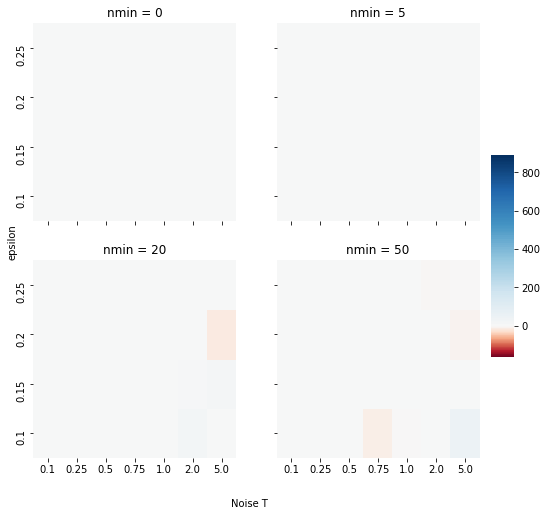

In [21]:
# Plot: for each nmin, make heatmap w/ diff as col, x=T, y=epsilon
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.92, 0.3, 0.04, .35])

for i, nm in enumerate(nminvals):
    pivot = aawide[aawide['nmin']==nm].pivot_table(index='epsilon', columns='T', values='word3highlow', aggfunc='median')
    sns.heatmap(pivot, ax=axs.flat[i],
                vmin=vmin, vmax=vmax, cmap='RdBu', norm=divnorm,
                cbar=True, cbar_ax=cbar_ax)
    axs.flat[i].invert_yaxis()
    axs.flat[i].set_title('nmin = {}'.format(nm))
    axs.flat[i].set(ylabel='', xlabel='')
    
#fig.delaxes(axs[1][2])
fig.text(0.5, 0.04, 'Noise T', ha='center')
fig.text(0.08, 0.5, 'epsilon', va='center', rotation='vertical')
plt.show()

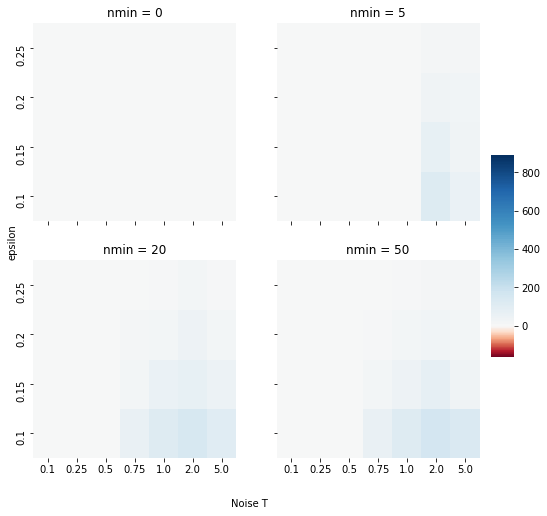

In [20]:
# Plot: for each nmin, make heatmap w/ diff as col, x=T, y=epsilon
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.92, 0.3, 0.04, .35])

for i, nm in enumerate(nminvals):
    pivot = aawide[aawide['nmin']==nm].pivot_table(index='epsilon', columns='T', values='word3highambig', aggfunc='median')
    sns.heatmap(pivot, ax=axs.flat[i], cmap='RdBu', norm=divnorm,
                vmin=vmin, vmax=vmax,
                cbar=True, cbar_ax=cbar_ax)
    axs.flat[i].invert_yaxis()
    axs.flat[i].set_title('nmin = {}'.format(nm))
    axs.flat[i].set(ylabel='', xlabel='')
    
#fig.delaxes(axs[1][2])
fig.text(0.5, 0.04, 'Noise T', ha='center')
fig.text(0.08, 0.5, 'epsilon', va='center', rotation='vertical')
plt.show()

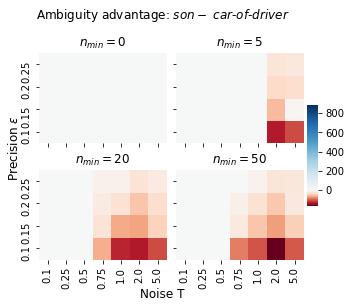

In [42]:
# Plot: for each nmin, make heatmap w/ diff as col, x=T, y=epsilon
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(4,4), sharex=True, sharey=True, constrained_layout=True)
cbar_ax = fig.add_axes([1.0, 0.3, 0.04, .35])

for i, nm in enumerate(nminvals):
    pivot = aawide[aawide['nmin']==nm].pivot_table(index='epsilon', columns='T', values='word3diff', aggfunc='median')
    s = sns.heatmap(pivot, ax=axs.flat[i], cmap='RdBu', norm=divnorm,
                vmin=vmin, vmax=vmax,
                cbar=True, cbar_ax=cbar_ax)#, cbar_kws={'label': 'Time steps'})
    axs.flat[i].invert_yaxis()
    axs.flat[i].set_title(r'$n_{{min}} = ${}'.format(nm))
    axs.flat[i].set(ylabel='', xlabel='')
    
fig.suptitle('Ambiguity advantage: $son -$ $car$-$of$-$driver$')
fig.text(0.5, -0.02, 'Noise T', ha='center', fontsize=12)
fig.text(-0.04, 0.5, 'Precision $\\epsilon$', va='center', rotation='vertical', fontsize=12)
plt.savefig(''.join(['AA', str(nruns), '.pdf']), bbox_inches='tight')
plt.show()

In [94]:
aawide.groupby(['nmin', 'epsilon', 'T']).word3diff.agg(['median', lambda x: np.quantile(x, 0.25), lambda x: np.quantile(x, 0.75)])

median  <lambda_0>  <lambda_1>
nmin epsilon T                                   
0    0.10    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0        0.00        0.00
             0.75     0.0      -68.00        0.00
             1.00     0.0     -207.00        0.00
             2.00     0.0     -560.50        5.00
             5.00     0.0         NaN         NaN
     0.15    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0        0.00        0.00
             0.75     0.0       -5.00        0.00
             1.00     0.0     -107.25        0.00
             2.00     0.0     -221.00       95.25
             5.00     0.0     -270.00      112.50
     0.20    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0        0.00        0.00
             0.75     0.0      -23.75        0.00
             1.00     0.0      -39.75        0.00
             2.00     0.0     -139.00       27.75
             5.00     0.0     -140.00       78.50
     0.25    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0        0.00        0.00
             0.75     0.0       -6.00        0.00
             1.00     0.0      -45.00        0.00
             2.00     0.0      -77.00       32.00
             5.00     0.0      -91.25       56.00
5    0.10    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0        0.00        0.00
             0.75     0.0     -115.00        0.00
             1.00     0.0     -313.25        0.00
             2.00  -130.0     -520.00       31.25
             5.00  -107.0     -457.00      247.50
     0.15    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0        0.00        0.00
             0.75     0.0      -58.00        0.00
             1.00     0.0     -119.00        0.00
             2.00   -52.0     -240.00       61.00
             5.00    -3.0     -175.00      138.50
     0.20    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0       -3.00        0.00
             0.75     0.0      -33.00        0.00
             1.00     0.0      -64.25        3.00
             2.00   -32.0     -145.50       36.75
             5.00   -28.0     -146.25       75.00
     0.25    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0        0.00        0.00
             0.75     0.0      -29.00        0.00
             1.00     0.0      -50.00        5.50
             2.00   -21.0      -84.25       37.25
             5.00   -17.0      -94.00       37.25
20   0.10    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0      -43.00        0.00
             0.75   -60.0     -174.00       25.00
             1.00  -125.5     -256.00        8.50
             2.00  -131.5     -330.50       45.00
             5.00  -106.5     -282.25       60.25
     0.15    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0      -21.00        0.00
             0.75   -22.5      -72.00       20.25
             1.00   -62.5     -128.75        1.25
             2.00   -65.5     -166.25       36.25
             5.00   -38.0     -144.25       69.50
     0.20    0.10     0.0        0.00        0.00
             0.25     0.0        0.00        0.00
             0.50     0.0      -14.00        0.00
             0.75   -14.0      -41.00        7.25
             1.00   -25.0      -62.25       19.25
             2.00   -45.5     -103.00       16.25
             5.00   -28.0      -96.00       39.00
     0.25    0.10     0.0        0.00        0.00
             0.25  

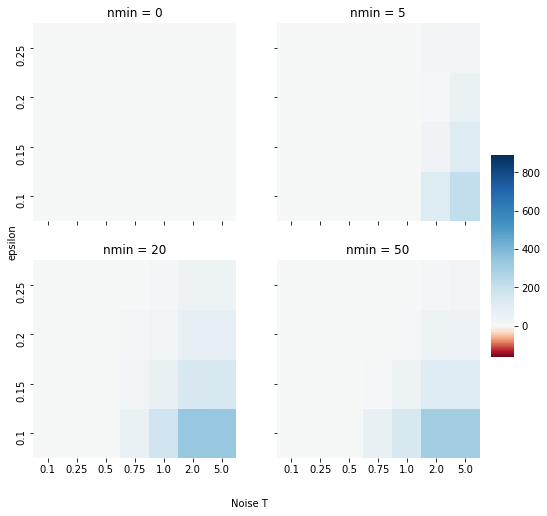

In [23]:
# Word 2: ambig should probably be > unambig
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8,8), sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.92, 0.3, 0.04, .35])


for i, nm in enumerate(nminvals):
    pivot = gpwide[gpwide['nmin']==nm].pivot_table(index='epsilon', columns='T', values='word2ambigunambig', aggfunc='median')
    sns.heatmap(pivot, ax=axs.flat[i], cmap='RdBu', norm=divnorm,
                vmin=vmin, vmax=vmax,
                cbar=True, cbar_ax=cbar_ax)
    axs.flat[i].invert_yaxis()
    axs.flat[i].set_title('nmin = {}'.format(nm))
    axs.flat[i].set(ylabel='', xlabel='')
    
#fig.delaxes(axs[1][2])
fig.text(0.5, 0.04, 'Noise T', ha='center')
fig.text(0.08, 0.5, 'epsilon', va='center', rotation='vertical')
#fig.tight_layout()
plt.show()

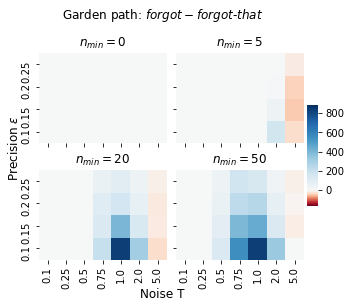

In [45]:
# Plot: for each nmin, make heatmap w/ diff as col, x=T, y=epsilon
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(4,4), sharex=True, sharey=True, constrained_layout=True)
cbar_ax = fig.add_axes([1.0, 0.3, 0.04, .35])

for i, nm in enumerate(nminvals):
    pivot = gpwide[gpwide['nmin']==nm].pivot_table(index='epsilon', columns='T', values='word3diff', aggfunc='median')
    s = sns.heatmap(pivot, ax=axs.flat[i], cmap='RdBu', norm=divnorm,
                vmin=vmin, vmax=vmax,
                cbar=True, cbar_ax=cbar_ax)#, cbar_kws={'label': 'Time steps'})
    axs.flat[i].invert_yaxis()
    axs.flat[i].set_title(r'$n_{{min}} = ${}'.format(nm))
    axs.flat[i].set(ylabel='', xlabel='')
    
fig.suptitle("Garden path: $forgot - forgot$-$that$")
fig.text(0.5, -0.02, 'Noise T', ha='center', fontsize=12)
fig.text(-0.04, 0.5, 'Precision $\\epsilon$', va='center', rotation='vertical', fontsize=12)
plt.savefig(''.join(['GP', str(nruns), '.pdf']), bbox_inches='tight')
plt.show()

In [31]:
gpwide.groupby(['nmin', 'epsilon', 'T']).word3ambigunambig.agg(['median', lambda x: np.quantile(x, 0.25), lambda x: np.quantile(x, 0.75)])

median  <lambda_0>  <lambda_1>
nmin epsilon T                                   
0    0.10    0.10     0.0      -52.00        0.00
             0.25     0.0      -52.00        0.00
             0.50     0.0         NaN         NaN
             0.75     0.0         NaN         NaN
             1.00     0.0         NaN         NaN
             2.00     0.0         NaN         NaN
             5.00     0.0     -672.00      143.50
     0.15    0.10     0.0      -38.00        0.00
             0.25     0.0      -38.00        0.00
             0.50     0.0      -38.00        0.00
             0.75     0.0      -52.00        0.00
             1.00     0.0     -117.00        0.00
             2.00     0.0     -251.00      221.50
             5.00     0.0     -252.00       84.75
     0.20    0.10     0.0      -31.00        0.00
             0.25     0.0      -31.00        0.00
             0.50     0.0      -31.00        0.00
             0.75     0.0      -38.00        0.00
             1.00     0.0      -65.75        0.00
             2.00     0.0     -117.00      119.00
             5.00     0.0     -165.00       75.00
     0.25    0.10     0.0      -23.00        0.00
             0.25     0.0      -23.00        0.00
             0.50     0.0      -23.00        0.00
             0.75     0.0      -32.00        0.00
             1.00     0.0      -45.00        0.00
             2.00     0.0      -86.00       80.00
             5.00     0.0      -89.25       43.25
5    0.10    0.10     0.0      -50.00        0.00
             0.25     0.0      -50.00        0.00
             0.50     0.0      -66.00        0.00
             0.75     0.0         NaN         NaN
             1.00     0.0         NaN         NaN
             2.00   171.0         NaN         NaN
             5.00   -29.0     -483.50      195.50
     0.15    0.10     0.0      -36.00        0.00
             0.25     0.0      -36.00        0.00
             0.50     0.0      -36.00        0.00
             0.75     0.0      -77.75        0.00
             1.00     0.0     -135.50      236.00
             2.00    43.5     -186.25      292.75
             5.00   -43.0     -250.00      130.75
     0.20    0.10     0.0      -29.00        0.00
             0.25     0.0      -29.00        0.00
             0.50     0.0      -29.00        0.00
             0.75     0.0      -50.00        0.00
             1.00     0.0      -70.50       94.50
             2.00     7.0      -93.25      163.00
             5.00   -37.5     -156.75       51.25
     0.25    0.10     0.0      -21.00        0.00
             0.25     0.0      -21.00        0.00
             0.50     0.0      -21.00        0.00
             0.75     0.0      -30.00        0.00
             1.00     0.0      -43.00       68.50
             2.00     0.0      -75.00      103.25
             5.00   -14.0      -94.25       53.25
20   0.10    0.10     0.0      -35.00        0.00
             0.25     0.0      -35.00        0.00
             0.50     0.0         NaN         NaN
             0.75   204.0         NaN         NaN
             1.00   834.0         NaN         NaN
             2.00   306.0         NaN         NaN
             5.00   -29.0     -219.75      166.25
     0.15    0.10     0.0      -21.00        0.00
             0.25     0.0      -21.00        0.00
             0.50     0.0      -28.00       16.00
             0.75   132.0         NaN         NaN
             1.00   405.0      142.25      624.75
             2.00   139.5       21.00      261.75
             5.00   -14.5     -136.00      114.00
     0.20    0.10     0.0      -14.00        0.00
             0.25     0.0      -14.00        0.00
             0.50     0.0      -15.00       23.75
             0.75   107.0      -18.00      285.75
             1.00   163.5       21.00      325.00
             2.00    72.5      -11.00      158.00
             5.00   -16.0     -103.00       61.00
     0.25    0.10     0.0       -6.00        0.00
             0.25  